Setup & Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_parquet("../data/processed/model_ready.parquet").copy()
aapl = df[df['ticker'] == 'AAPL'][['close']].copy()

 Time Series Decomposition

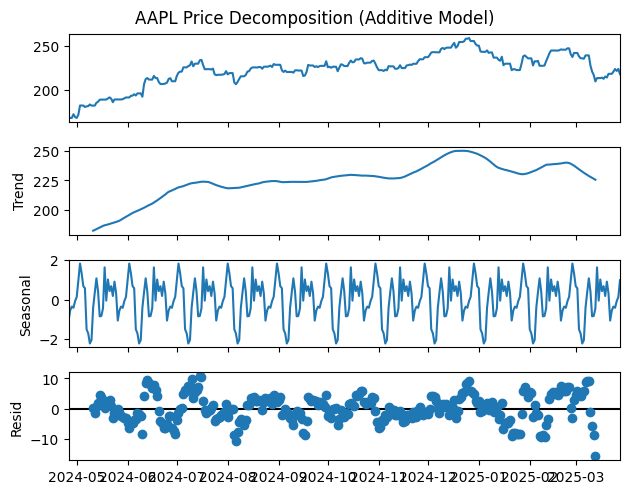

In [4]:
decomposition = seasonal_decompose(aapl, period=30, model='additive')  
decomposition.plot()
plt.suptitle('AAPL Price Decomposition (Additive Model)', y=1.02)
plt.savefig('../notebooks/visualizations/decomposition.png', bbox_inches='tight')
plt.show()

Stationarity Testing
Augmented Dickey-Fuller (ADF) Test

In [5]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for k, v in result[4].items():
        print(f"\t{k}: {v:.3f}")

adf_test(aapl)

#p-value < 0.05 → Series is stationary.

#p-value > 0.05 → Non-stationary (needs differencing).

ADF Statistic: -2.9742
p-value: 0.0374
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


KPSS Test (Complementary Check)


In [6]:
def kpss_test(series):
    result = kpss(series, regression='c')
    print(f"KPSS Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for k, v in result[3].items():
        print(f"\t{k}: {v:.3f}")

kpss_test(aapl)

#p-value < 0.05 → Non-stationary.


#p-value > 0.05 → Stationary.

KPSS Statistic: 1.7898
p-value: 0.0100
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\Alaa\AppData\Local\Temp\ipykernel_3804\303744078.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')


Making the Series Stationary

First Differencing

In [7]:
aapl_diff = aapl.diff().dropna()
adf_test(aapl_diff)  

ADF Statistic: -16.8481
p-value: 0.0000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


Log Returns (Alternative)

In [8]:
aapl_log_returns = np.log(aapl / aapl.shift(1)).dropna()
adf_test(aapl_log_returns)

ADF Statistic: -16.8239
p-value: 0.0000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


ACF & PACF Plots (for ARIMA Parameters)
Autocorrelation (ACF)

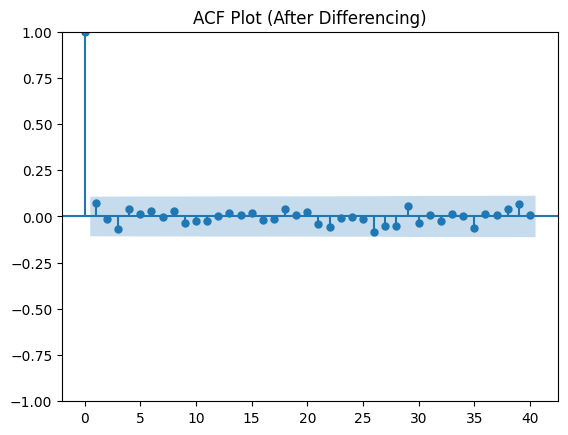

In [9]:
plot_acf(aapl_diff, lags=40, alpha=0.05)
plt.title('ACF Plot (After Differencing)')
plt.savefig('../notebooks/visualizations/acf_plot.png', bbox_inches='tight')
plt.show()

Partial Autocorrelation (PACF)

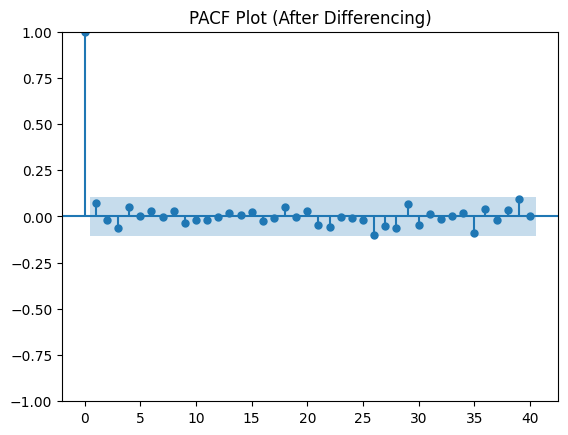

In [10]:
plot_pacf(aapl_diff, lags=40, alpha=0.05, method='ols')
plt.title('PACF Plot (After Differencing)')
plt.savefig('../notebooks/visualizations/pacf_plot.png', bbox_inches='tight')
plt.show()